In [1]:
from time import time
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib
import matplotlib.pyplot as plt

#отображение графиков в ноутбуке
%matplotlib inline 

#для четкой прорисовки графиков
%config InlineBackend.figure_format = 'svg'

In [9]:
def euclidean_distance(X, Y):
    answer = np.linalg.norm(X, axis=-1)[:, None] ** 2 + \
        np.linalg.norm(Y, axis=-1)[None, :] ** 2 - (2.0 * X) @ Y.T
    answer[answer < 0] = 0
    return np.sqrt(answer)


def cosine_distance(X, Y):
    X_norm = np.linalg.norm(X, axis=-1)
    Y_norm = np.linalg.norm(Y, axis=-1)
    X_norm[X_norm == 0] = 1
    Y_norm[Y_norm == 0] = 1
    result = X @ Y.T
    result /= X_norm[:, None]
    result /= Y_norm[None, :]
    return 1.0 - result

In [10]:
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed


class KNNClassifier:
    def __init__(self, k,
                 strategy='my_own',
                 metric='euclidean',
                 weights=False,
                 test_block_size=1000):
        """
        [] k - число ближайших соседей;
        [] strategy - алгоритм поиска ближайших соседей:
         -- 'my_own' - собственная реализация,
         -- 'brute' -
                    sklearn.neighbors.NearestNeighbors(algorithm='brute'),
         -- 'kd_tree' -
                    sklearn.neighbors.NearestNeighbors(algorithm='kd_tree'),
         -- 'ball_tree' -
                    sklearn.neighbors.NearestNeighbors(algorithm='ball_tree');
        [] metric - название метрики, по которой считается расстояние
                    между объектами:
         -- 'euclidean' - евклидова метрика,
         -- 'cosine' - косинусная метрика;
        [] weights - bool переменная:
         -- True - нужно использовать взвешенный метод,
         -- False - не нужно;
        [] test_block_size - размер блока данных для тестовой выборки;
        """
        self.k = k
        self.strategy = strategy
        self.metric = metric
        self.weights = weights
        self.epsilon = 0.00001
        self.test_block_size = test_block_size
        self.train_classes = None
        self.y_train = None
        if self.strategy == 'my_own':
            self.X_train = None
        else:
            self.model = NearestNeighbors(algorithm=self.strategy,
                                          metric=self.metric)

    def fit(self, X, y):
        """
        [] X - обучающая выборка объектов;
        [] y - ответы объектов из обучающей выборки;
        """
        self.y_train = y
        if self.strategy == 'my_own':
            self.X_train = X
        else:
            self.model.fit(X)
        self.train_classes = np.unique(y)
        return self

    def predict(self, X):
        """
        [] X - тестовая выборка объектов;
        """
        if self.weights:
            dists, inds = self.find_kneighbors(X, True)
            return self.predict_weighted(dists, inds)
        else:
            inds = self.find_kneighbors(X, False)
            return self.predict_simple(inds)

    def predict_weighted(self, dists, inds):
        classes = np.take_along_axis(self.y_train[None, :], inds, axis=1)
        classes_counts = []
        votes = 1.0 / (dists + self.epsilon)
        for class_id in self.train_classes:
            classes_counts.append((votes * (classes == class_id)).sum(axis=1))
        ind = np.vstack(classes_counts).argmax(axis=0)
        return np.take_along_axis(self.train_classes, ind, axis=0)

    def predict_simple(self, inds):
        classes = np.take_along_axis(self.y_train[None, :], inds, axis=1)
        classes_counts = []
        for class_id in self.train_classes:
            classes_counts.append((classes == class_id).sum(axis=1))
        ind = np.vstack(classes_counts).argmax(axis=0)
        return np.take_along_axis(self.train_classes, ind, axis=0)
    
    def find_kneighbors(self, X, return_distance):
        """
        [] X - тестовая выборка объектвов;
        [] return_distance - переменная типа bool;
        """
        if self.strategy == 'my_own':
            return self.find_kneighbors_my_own_job(X, return_distance)
        else:
            return self.model.kneighbors(X, n_neighbors=self.k,
                                         return_distance=return_distance)
    
    def find_kneighbors_my_own(self, X, return_distance):
        def my_job(X_part):
            return self.find_kneighbors_my_own_job(X_part, return_distance)
        
        result = Parallel(n_jobs=3)([
                delayed(my_job)
                (X[start:min(start + self.test_block_size, X.shape[0]), :])
                for start in range(0, X.shape[0], self.test_block_size)
            ])
        if return_distance:
            return np.vstack([t[0] for t in result]), np.vstack([t[1] for t in result])
        else:
            return np.vstack(result)
    
    def find_kneighbors_my_own_job(self, X, return_distance):
        if self.metric == 'euclidean':
            dist = euclidean_distance(X, self.X_train)
        elif self.metric == 'cosine':
            dist = cosine_distance(X, self.X_train)
        else:
            raise TypeError
        if self.k < dist.shape[1]:
            ind_in_block = dist.argpartition(self.k, axis=1)[:, :self.k]
            block_k = np.take_along_axis(dist, ind_in_block, axis=1)
        else:
            block_k = dist
            rang = np.arange(0, dist.shape[1])
            ind_in_block = np.vstack([rang for _ in range(X.shape[0])])
        ind_in_block_k = block_k.argsort(axis=1)
        ind = np.take_along_axis(ind_in_block, ind_in_block_k, axis=1)
        if return_distance:
            return (np.take_along_axis(block_k, ind_in_block_k, axis=1), ind)
        else:
            return ind

In [11]:
def kfold(n, n_folds):
    indexes = np.arange(0, n)
    sizes = np.full(n_folds, n // n_folds)
    sizes[:n % n_folds] += 1
    coords = np.cumsum(np.array([sizes, sizes]), axis=1)
    coords[0, :] -= sizes
    mask = np.full(n, True)
    answer = []
    for coord in coords.T:
        coord = slice(coord[0], coord[1])
        mask[coord] = False
        answer.append((indexes[mask], indexes[coord]))
        mask[coord] = True
    return answer


def knn_cross_val_score(X, y, k_list, score='accuracy', cv=None, **kwargs):
    EPSILON = 0.00001
    if cv is None:
        s = X.shape[0]
        cv = kfold(s, s if s < 3 else 3)
    stat = []
    for train, test in cv:
        X_train, X_test, y_train, y_test =\
            X[train, :], X[test, :], y[train], y[test]
        knn = KNNClassifier(k=k_list[-1], **kwargs)
        knn.fit(X_train, y_train)
        k_list.insert(0, 0)
        classes_id = np.unique(y_train)
        cv_result = []
        if kwargs['weights']:
            dists, indexes = knn.find_kneighbors(X_test, return_distance=True)
            votes = 1.0 / (dists + EPSILON)
            classes = np.take_along_axis(y_train[None, :], indexes, axis=1)
            classes_counts = np.zeros((classes.shape[0], classes_id.shape[0]), dtype=float)
            for i in range(1, len(k_list)):
                current_neighs = classes[:, k_list[i - 1]:k_list[i]]
                votes_neighs = votes[:, k_list[i - 1]:k_list[i]]
                for j, class_id in enumerate(classes_id):
                    classes_counts[:, j] += \
                        (votes_neighs * (current_neighs == class_id)).sum(axis=1)
                ind = classes_counts.argmax(axis=1)
                pred = np.take_along_axis(classes_id, ind, axis=0)
                cv_result.append((pred == y_test).sum() / y_test.shape[0])
        else:
            indexes = knn.find_kneighbors(X_test, return_distance=False)
            classes = np.take_along_axis(y_train[None, :], indexes, axis=1)
            classes_counts = np.zeros((classes.shape[0], classes_id.shape[0]), dtype=int)
            for i in range(1, len(k_list)):
                current_neighs = classes[:, k_list[i - 1]:k_list[i]]
                for j, class_id in enumerate(classes_id):
                    classes_counts[:, j] += (current_neighs == class_id).sum(axis=1)
                ind = classes_counts.argmax(axis=1)
                pred = np.take_along_axis(classes_id, ind, axis=0)
                cv_result.append((pred == y_test).sum() / y_test.shape[0])
        k_list.pop(0)
        stat.append(cv_result)
    stat = np.array(stat)
    return {k: stat[:, i].ravel() for i, k in enumerate(k_list)}

In [16]:
# X, y = fetch_openml('mnist_784', return_X_y=True)

In [17]:
# np.save('mnist_784_X', X)
# np.save('mnist_784_y', y)

In [2]:
start = time()
X, y = np.load('mnist_784_X.npy', allow_pickle=True), np.load('mnist_784_y.npy', allow_pickle=True)
X_train, X_test, y_train, y_test = X[:-10000, :], X[-10000:, :], y[:-10000], y[-10000:]
end = time()
print(end - start)
print(type(X), X.shape)
print(type(y), y.shape)
print(X.dtype, y.dtype)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

0.21609020233154297
<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)
float64 int64
(60000, 784)
(10000, 784)
(60000,)
(10000,)


In [14]:
# del X, X_train, X_test, y, y_train, y_test

In [6]:
# start = time()
# X = np.load('mnist_784_X.npy', allow_pickle=True)
# y = np.load('mnist_784_y.npy', allow_pickle=True)
# end = time()
# print('Load time:', end - start)
# print(type(X), X.shape)
# print(type(y), y.shape)
# print(X.dtype, y.dtype)

In [5]:
# X_train, X_test = np.array(X[:-10000, :]), np.array(X[-10000:, :])
# y_train, y_test = np.array(y[:-10000]), np.array(y[-10000:])
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [13]:
# simple KNN test
knn = KNNClassifier(4, metric='cosine', strategy='my_own')
knn.fit(X_train, y_train)

In [ ]:
start = time()
y_pred = knn.predict(X_test)
end = time()
print(accuracy_score(y_test, y_pred))
print(end - start)

# EXPERIMENTS OF TASK 1

## EXPERIMENT 1

### DESCRIPTION EXP 1

Необходимо исследовать какой из алгоритмов поиска ближайших соседей работает быстрее в различных ситуациях.
В эксперименте будет вестись поиск 5 ближайших соседей для каждого объекта тестовой выборки,
а метрикой расстояния между объектами будет рассмотрена евклидова метрика.
Будут исследованиы следующие стратегии поиска: ручная реализация и библиотечные реализации: kd_tree, ball_tree, brute.
Датасет будет формироватья из случайного подмножеста признаков в количестве: 10, 20, 100.

In [12]:
from time import time
import numpy as np

In [80]:
STRATEGIES = ['my_own', 'brute', 'kd_tree', 'ball_tree']
K = 5
METRIC = 'euclidean'
FEATURES = [10, 20, 100]
stat = {
    n: {
        s: None
        for s in STRATEGIES
    }
    for n in FEATURES
}

In [12]:
import json


rng = np.random.default_rng()

for n in FEATURES:
    coords = np.arange(X_train.shape[1])
    rng.shuffle(coords)
    coords = np.sort(coords[:n])
    X_train_sub, X_test_sub = np.array(X_train[:, coords]), np.array(X_test[:, coords])
    for s in STRATEGIES:
        print('Features:', n, 'Strategy:', s, 'Time:', sep='\t', end='\t')
        if stat[n][s] is not None:
            print(stat[n][s], 'PREVIOUS', sep='\t')
            continue
        knn = KNNClassifier(k=K, strategy=s, metric=METRIC)
        knn.fit(X_train_sub, y_train)
        start = time()
        knn.find_kneighbors(X_test_sub, False)
        end = time()
        stat[n][s] = end - start
        print(end - start)
        with open("experiment1.json", "w") as write_file:
            json.dump(stat, write_file)
with open("experiment1.json", "w") as write_file:
    json.dump(stat, write_file)

Features:	10	Strategy:	my_own	Time:	11.403591394424438
Features:	10	Strategy:	brute	Time:	0.6650972366333008
Features:	10	Strategy:	kd_tree	Time:	3.7563343048095703
Features:	10	Strategy:	ball_tree	Time:	3.670999050140381
Features:	20	Strategy:	my_own	Time:	6.353355169296265
Features:	20	Strategy:	brute	Time:	0.48292064666748047
Features:	20	Strategy:	kd_tree	Time:	5.563888311386108
Features:	20	Strategy:	ball_tree	Time:	13.008382797241211
Features:	100	Strategy:	my_own	Time:	6.650333881378174
Features:	100	Strategy:	brute	Time:	0.9585871696472168
Features:	100	Strategy:	kd_tree	Time:	79.96534776687622
Features:	100	Strategy:	ball_tree	Time:	67.13572788238525


In [81]:
import json


with open("experiment1.json", "r") as read_file:
    stat = json.load(read_file)
stat

{'10': {'my_own': 11.403591394424438,
  'brute': 0.6650972366333008,
  'kd_tree': 3.7563343048095703,
  'ball_tree': 3.670999050140381},
 '20': {'my_own': 6.353355169296265,
  'brute': 0.48292064666748047,
  'kd_tree': 5.563888311386108,
  'ball_tree': 13.008382797241211},
 '100': {'my_own': 6.650333881378174,
  'brute': 0.9585871696472168,
  'kd_tree': 79.96534776687622,
  'ball_tree': 67.13572788238525}}

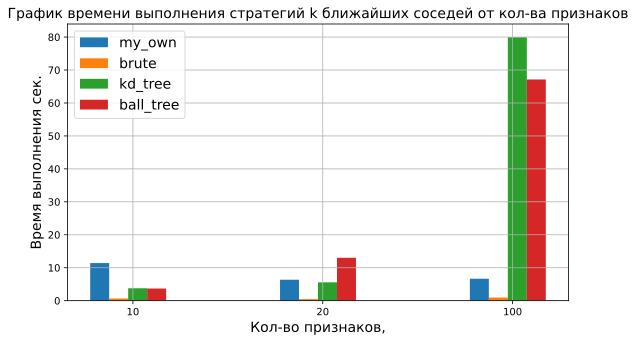

In [83]:
# задаем размеры
plt.figure(figsize=(9,5))

# заголовок 
plt.title('График времени выполнения стратегий k ближайших соседей от кол-ва признаков', fontsize=14)

# ширина столбцов
width = 0.10

AMOUNT = len(STRATEGIES)

# координаты столбцов
ids = np.arange(1,4)

# рисуем графики
for i, s in enumerate(STRATEGIES):
    plt.bar(ids + i * width + width / AMOUNT, [stat[str(f)][s] for f in FEATURES], width, label=s)

plt.xticks(ids + 2 * width, FEATURES)

# подписи осей
plt.xlabel('Кол-во признаков,', fontsize=14)
plt.ylabel('Время выполнения сек.', fontsize=14)

# легенда для разных цветов
plt.legend(fontsize=14)

# сетка графика
plt.grid(True) 

plt.savefig('experiment1_chart1.pdf')
plt.show()

### CONCLUSION EXP 1

Был произведен подсчет времени нахождения 5 ближайших соседей для каждого объекта тестовой  
выборки с помощью алгоритмов: my_own, brute, kd_tree, ball_tree.  
Алгоритм brute показал себя наилучшим образом, что объясняется малыми для него размерами выборки.  
Собственная реализация примерно в 6-10 раз медленнее brute алгоритма, но ассимптотика та же  
из-за одного и того же алгоритма.  
Алгоритмы на основе деревьев в данном эксперименте медленее brute в 60-80 раз.  
На 10 и 20 признаках ball_tree медленее kd_tree в 2-5 раз, но при 100 признаках ball_tree  
работает в 1.17 раз быстрее kd_tree.

## EXPERIMENT 2

### DESCRIPTION EXP 2

Необходимо оценить по кросс-валидации на 3 фолдах точность и время работы алгоритма k ближайших  
соседей в зависимости от значений k с 1 до 10 и от евклидовой или косинусной метрики.  
Требуется выяснить какая из метрик даст лучший результат на рассматриваемом датасете и исследовать  
график точности от количества соседей на предмет выбросов (резких падений и улучшений точности).

In [10]:
from time import time
import numpy as np

In [84]:
STRATEGIES = ['my_own', 'brute', 'kd_tree', 'ball_tree']
K = [i for i in range(1, 11)]
METRICS = ['euclidean', 'cosine']
FOLDS = 3

In [13]:
stat = {
    s: {
        m: {
            str(k): None
            for k in K
        }
        for m in METRICS
    }
    for s in STRATEGIES
}

In [14]:
rng = np.random.default_rng()
coords = np.arange(X_train.shape[1])
rng.shuffle(coords)
coords = np.sort(coords)
X_sub = np.array(X[:, coords])
folds = kfold(y.shape[0], FOLDS)

for s in STRATEGIES:
    for m in METRICS:
        if stat[s][m][K[0]] is not None:
            continue
        try:
            start = time()
            result = knn_cross_val_score(X_sub, y, K, 'accuracy', folds, metric=m, strategy=s, weights=False)
            end = time()
            for k, arr in result.items():
                stat[s][m][str(k)] = ((end - start) / FOLDS, arr.mean())
                print('Strategy:', s,
                      'Metric:', m,
                      'K:', k,
                      'Time:', stat[s][m][k][0],
                      'Accuracy:', stat[s][m][k][1],
                      sep='\t')
        except BaseException:
            pass

import json


with open("experiment2.json", "w") as write_file:
    json.dump(stat, write_file)

Strategy:	my_own	Metric:	euclidean	K:	1	Time:	23.502187569936115	Accuracy:	0.9678714036607117
Strategy:	my_own	Metric:	euclidean	K:	2	Time:	23.502187569936115	Accuracy:	0.9620285634540031
Strategy:	my_own	Metric:	euclidean	K:	3	Time:	23.502187569936115	Accuracy:	0.9687856981507553
Strategy:	my_own	Metric:	euclidean	K:	4	Time:	23.502187569936115	Accuracy:	0.9672142673338193
Strategy:	my_own	Metric:	euclidean	K:	5	Time:	23.502187569936115	Accuracy:	0.9673571271297582
Strategy:	my_own	Metric:	euclidean	K:	6	Time:	23.502187569936115	Accuracy:	0.9663999761090759
Strategy:	my_own	Metric:	euclidean	K:	7	Time:	23.502187569936115	Accuracy:	0.9667285516193558
Strategy:	my_own	Metric:	euclidean	K:	8	Time:	23.502187569936115	Accuracy:	0.9656714138637494
Strategy:	my_own	Metric:	euclidean	K:	9	Time:	23.502187569936115	Accuracy:	0.9648285520267379
Strategy:	my_own	Metric:	euclidean	K:	10	Time:	23.502187569936115	Accuracy:	0.9645428446795833
Strategy:	my_own	Metric:	cosine	K:	1	Time:	19.3758636315663

In [85]:
import json


with open("experiment2.json", "r") as read_file:
    stat = json.load(read_file)
stat

{'my_own': {'euclidean': {'1': [23.502187569936115, 0.9678714036607117],
   '2': [23.502187569936115, 0.9620285634540031],
   '3': [23.502187569936115, 0.9687856981507553],
   '4': [23.502187569936115, 0.9672142673338193],
   '5': [23.502187569936115, 0.9673571271297582],
   '6': [23.502187569936115, 0.9663999761090759],
   '7': [23.502187569936115, 0.9667285516193558],
   '8': [23.502187569936115, 0.9656714138637494],
   '9': [23.502187569936115, 0.9648285520267379],
   '10': [23.502187569936115, 0.9645428446795833]},
  'cosine': {'1': [19.375863631566364, 0.9720999712135132],
   '2': [19.375863631566364, 0.9690142501919419],
   '3': [19.375863631566364, 0.9730999806015425],
   '4': [19.375863631566364, 0.9723142685603733],
   '5': [19.375863631566364, 0.9723999822338865],
   '6': [19.375863631566364, 0.9720142789682655],
   '7': [19.375863631566364, 0.970928551008834],
   '8': [19.375863631566364, 0.9707142726412946],
   '9': [19.375863631566364, 0.969885699171598],
   '10': [19.3758

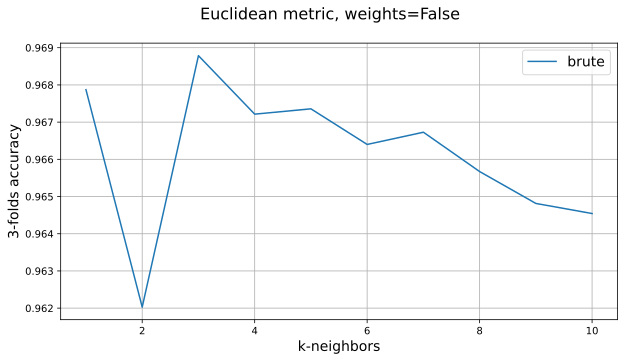

In [88]:
plt.figure(figsize=(10, 5))

plt.suptitle('Euclidean metric, weights=False', fontsize=16)

prev = []

for i, s in enumerate(['brute'], 1):
    prev.append(np.array([stat[s]['euclidean'][str(k)][1] for k in K]))
    plt.plot(K, prev[-1], label=s)
    
plt.legend(fontsize=14)
plt.xlabel('k-neighbors', fontsize=14)
plt.ylabel('3-folds accuracy', fontsize=14)
plt.grid(True)
plt.savefig('experiment2_chart1.pdf')
plt.show()

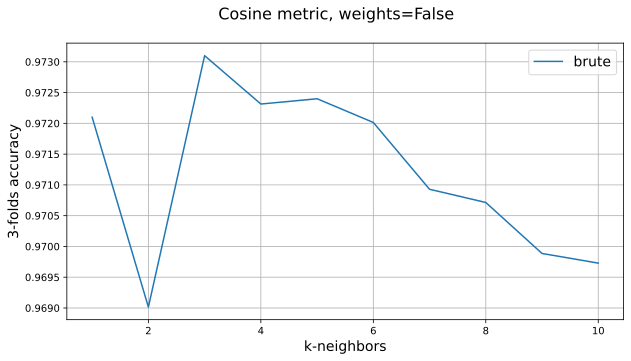

In [89]:
plt.figure(figsize=(10, 5))

plt.suptitle('Cosine metric, weights=False', fontsize=16)

prev = []

for i, s in enumerate(['brute'], 1):
    if stat[s]['cosine'][str(K[0])] is None:
        continue
    prev.append(np.array([stat[s]['cosine'][str(k)][1] for k in K]))
    plt.plot(K, prev[-1], label=s)
    
plt.legend(fontsize=14)
plt.xlabel('k-neighbors', fontsize=14)
plt.ylabel('3-folds accuracy', fontsize=14)
plt.grid(True)
plt.savefig('experiment2_chart2.pdf')
plt.show()

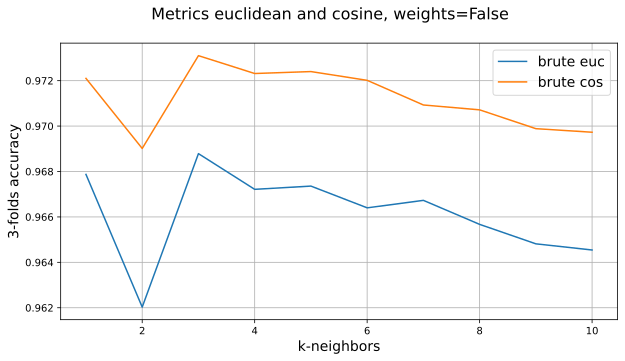

In [90]:
plt.figure(figsize=(10, 5))

plt.suptitle('Metrics euclidean and cosine, weights=False', fontsize=16)

prev_euc = []
prev_cos = []

for i, s in enumerate(['brute'], 1):
    prev_euc.append(np.array([stat[s]['euclidean'][str(k)][1] for k in K]))
    plt.plot(K, prev_euc[-1], label=s + ' euc')
    if stat[s]['cosine'][str(K[0])] is None:
        continue
    prev_cos.append(np.array([stat[s]['cosine'][str(k)][1] for k in K]))
    plt.plot(K, prev_cos[-1], label=s + ' cos')
    
plt.legend(fontsize=14)
plt.xlabel('k-neighbors', fontsize=14)
plt.ylabel('3-folds accuracy', fontsize=14)
plt.grid(True)
plt.savefig('experiment2_chart3.pdf')
plt.show()

### CONCLUSION EXP 2

Была произведена оценка точности алгоритма ближайших соседей по кросс-валидации с 3 фолдами  
при различных параметрах: k от 1 до 10, евклидова и косинусная метрики.

Лучше всего себя показала косинусная метрика, которая превзошла евклидову при любом k от 1 до 10.  
Это могло произойти из-за того, что признаки в пустых пространствах равны нулю,  
а значит в скалярном произведении косинусной метрики учитываются различия только в тех координатах,  
которые несут информацию для обоих объектов, когда в евклидовой учитываются любые несовпадения.  
Это позволяет косинусной метрике учитывать только основной каркас символов и не отвлекаться на  
неровности по краям, отличающиеся на всех рисунках.  

На графиках зависимости точности от количества соседей для обеих метрик наблюдается резкий спад  
точности при количестве соседей равном 2. Это объясняется случайным выбором правильного ответа при  
равном количестве голосов каждого класса.

## EXPERIMENT 3

### DESCRIPTION EXP 3

Неоходимо произвести второй эксперимент, но на взвешенном алгоритме k ближайших соседей  
и сравнить с обычным алгоритмом.

In [25]:
from time import time
import numpy as np

In [91]:
STRATEGIES = ['my_own', 'brute', 'kd_tree', 'ball_tree']
K = [i for i in range(1, 11)]
METRICS = ['euclidean', 'cosine']
FOLDS = 3

In [33]:
stat_weighted = {
    s: {
        m: {
            str(k): None
            for k in K
        }
        for m in METRICS
    }
    for s in STRATEGIES
}

In [34]:
import json


rng = np.random.default_rng()
coords = np.arange(X_train.shape[1])
rng.shuffle(coords)
coords = np.sort(coords)
X_sub = np.array(X[:, coords])
folds = kfold(y.shape[0], FOLDS)

for s in STRATEGIES:
    for m in METRICS:
        if stat_weighted[s][m][K[0]] is not None:
            continue
        try:
            start = time()
            result = knn_cross_val_score(X_sub, y, K, 'accuracy', folds, metric=m, strategy=s, weights=True)
            end = time()
            for k, arr in result.items():
                stat_weighted[s][m][str(k)] = ((end - start) / FOLDS, arr.mean())
                print('Strategy:', s,
                      'Metric:', m,
                      'K:', k,
                      'Time:', stat_weighted[s][m][k][0],
                      'Accuracy:', stat_weighted[s][m][k][1],
                      sep='\t')
        except BaseException:
            pass
        with open("experiment3.json", "w") as write_file:
            json.dump(stat_weighted, write_file)
with open("experiment3.json", "w") as write_file:
    json.dump(stat_weighted, write_file)

Strategy:	my_own	Metric:	euclidean	K:	1	Time:	19.95639165242513	Accuracy:	0.9678714036607117
Strategy:	my_own	Metric:	euclidean	K:	2	Time:	19.95639165242513	Accuracy:	0.9678714036607117
Strategy:	my_own	Metric:	euclidean	K:	3	Time:	19.95639165242513	Accuracy:	0.969985693865592
Strategy:	my_own	Metric:	euclidean	K:	4	Time:	19.95639165242513	Accuracy:	0.9704428334576619
Strategy:	my_own	Metric:	euclidean	K:	5	Time:	19.95639165242513	Accuracy:	0.9685999830486504
Strategy:	my_own	Metric:	euclidean	K:	6	Time:	19.95639165242513	Accuracy:	0.9692713997837873
Strategy:	my_own	Metric:	euclidean	K:	7	Time:	19.95639165242513	Accuracy:	0.9677571193749303
Strategy:	my_own	Metric:	euclidean	K:	8	Time:	19.95639165242513	Accuracy:	0.9680285548851458
Strategy:	my_own	Metric:	euclidean	K:	9	Time:	19.95639165242513	Accuracy:	0.9662428401905454
Strategy:	my_own	Metric:	euclidean	K:	10	Time:	19.95639165242513	Accuracy:	0.9662856948844754
Strategy:	my_own	Metric:	cosine	K:	1	Time:	20.12466247876485	Accuracy:

In [92]:
import json


with open("experiment3.json", "r") as read_file:
    stat_weighted = json.load(read_file)
stat_weighted

{'my_own': {'euclidean': {'1': [19.95639165242513, 0.9678714036607117],
   '2': [19.95639165242513, 0.9678714036607117],
   '3': [19.95639165242513, 0.969985693865592],
   '4': [19.95639165242513, 0.9704428334576619],
   '5': [19.95639165242513, 0.9685999830486504],
   '6': [19.95639165242513, 0.9692713997837873],
   '7': [19.95639165242513, 0.9677571193749303],
   '8': [19.95639165242513, 0.9680285548851458],
   '9': [19.95639165242513, 0.9662428401905454],
   '10': [19.95639165242513, 0.9662856948844754]},
  'cosine': {'1': [20.12466247876485, 0.9720999712135132],
   '2': [20.12466247876485, 0.9720999712135132],
   '3': [20.12466247876485, 0.9735999834588486],
   '4': [20.12466247876485, 0.9740999801937931],
   '5': [20.12466247876485, 0.9734857040709564],
   '6': [20.12466247876485, 0.9736999812140236],
   '7': [20.12466247876485, 0.9721856989684579],
   '8': [20.12466247876485, 0.9724999848869506],
   '9': [20.12466247876485, 0.9711999803966882],
   '10': [20.12466247876485, 0.9711

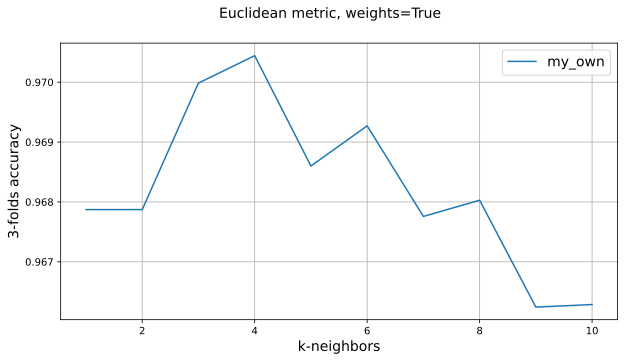

In [93]:
plt.figure(figsize=(10, 5))

plt.suptitle('Euclidean metric, weights=True', fontsize=14)

prev = []

for i, s in enumerate(['my_own'], 1):
    prev.append(np.array([stat_weighted[s]['euclidean'][str(k)][1] for k in K]))
    plt.plot(K, prev[-1], label=s)

plt.legend(fontsize=14)
plt.xlabel('k-neighbors', fontsize=14)
plt.ylabel('3-folds accuracy', fontsize=14)
plt.grid(True)
plt.savefig('experiment3_chart1.pdf')
plt.show()

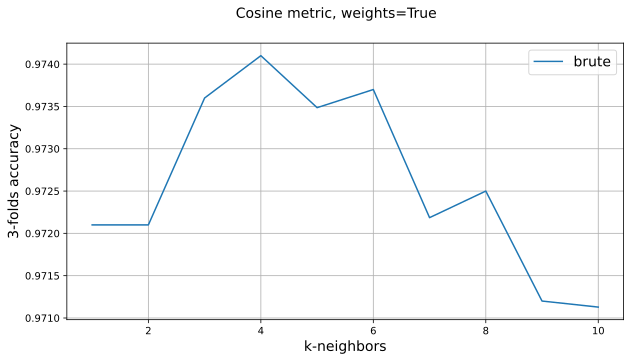

In [94]:
plt.figure(figsize=(10, 5))

plt.suptitle('Cosine metric, weights=True', fontsize=14)

prev = []

for i, s in enumerate(['brute'], 1):
    if stat_weighted[s]['cosine'][str(K[0])] is None:
        continue
    prev.append(np.array([stat_weighted[s]['cosine'][str(k)][1] for k in K]))
    plt.plot(K, prev[-1], label=s)

plt.legend(fontsize=14)
plt.xlabel('k-neighbors', fontsize=14)
plt.ylabel('3-folds accuracy', fontsize=14)
plt.grid(True)
plt.savefig('experiment3_chart2.pdf')
plt.show()

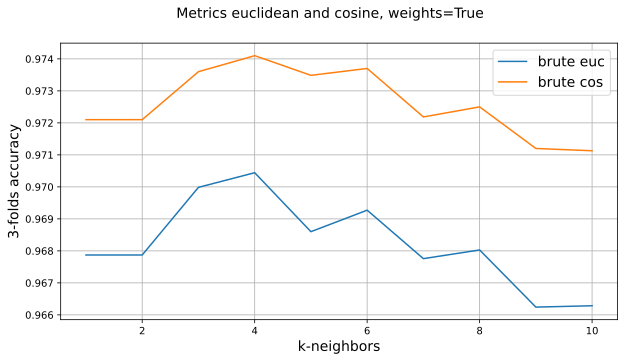

In [95]:
plt.figure(figsize=(10, 5))

plt.suptitle('Metrics euclidean and cosine, weights=True', fontsize=14)

prev_euc_weighted = []
prev_cos_weighted = []

for i, s in enumerate(['brute'], 1):
    prev_euc_weighted.append(np.array([stat_weighted[s]['euclidean'][str(k)][1] for k in K]))
    plt.plot(K, prev_euc_weighted[-1], label=s + ' euc')
    plt.legend(fontsize=10)
    if stat[s]['cosine'][str(K[0])] is None:
        continue
    prev_cos_weighted.append(np.array([stat_weighted[s]['cosine'][str(k)][1] for k in K]))
    plt.plot(K, prev_cos_weighted[-1], label=s + ' cos')

plt.legend(fontsize=14)
plt.xlabel('k-neighbors', fontsize=14)
plt.ylabel('3-folds accuracy', fontsize=14)
plt.grid(True)
plt.savefig('experiment3_chart3.pdf')
plt.show()

In [22]:
prev1 = prev_euc + prev_euc_weighted
for arr1 in prev1:
    for arr2 in prev1:
        if arr1 is not arr2:
            print(arr1 > arr2)
    print('---')

[False False False False False False False False  True False]
[False False False False False False False False  True False]
[False False False False False False False False False False]
[False False False False False False False False False False]
[False False False False False False False False False False]
[False False False False False False False False False False]
[False False False False False False False False False False]
---
[False False False False False False False False False False]
[False False False False False False False False False False]
[False False False False False False False False False False]
[False False False False False False False False False False]
[False False False False False False False False False False]
[False False False False False False False False False False]
[False False False False False False False False False False]
---
[False False False False False False False False False False]
[False False False False False False False False False False]


In [23]:
prev = prev_cos + prev_cos_weighted
for arr1 in prev:
    for arr2 in prev:
        if arr1 is not arr2:
            print(arr1 > arr2)
    print('---')

[False False False False False False False False False False]
[False False False False False False False False False False]
[False False False False False False False False False False]
---
[False False False False False False False False False False]
[False False False False False False False False False False]
[False False False False False False False False False False]
---
[False  True  True  True  True  True  True  True  True  True]
[False  True  True  True  True  True  True  True  True  True]
[False False False False False False False False False False]
---
[False  True  True  True  True  True  True  True  True  True]
[False  True  True  True  True  True  True  True  True  True]
[False False False False False False False False False False]
---


In [24]:
prev_cos_weighted[0] == prev_cos_weighted[1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

### CONCLUSION EXP 3

Была произведена оценка по кросс-валидации на 3 фолдах для взвешенного алгоритма k ближайших соседей  
на тех же параметрах, что и в 3 эксперименте. Взвешенный алгоритм показал себя лучше обычного на всех  
вариациях параметров (и совпал при 1 соседе). Лучшим алгоритмом оказался взвешенный my_own с 4  
соседями на косинусной метрике.

## EXPERIMENT 4

### DESCRIPTION EXP 4

Требуется исследовать лучший по результатам первых трех экспериментов алгоритм. Необходимо  
подсчитать точность и сраввнить её с тоностью по кросс-валидации, а также с точностью, указанной  
в интернете.  
Сдедует произвести анализ ошибок алгоритма, построив confusion matrix.  
Требуется визуализировать объекты, на которых допущены ошибки и выявить их общие черты.

In [8]:
knn = KNNClassifier(k=4, strategy='my_own', metric='cosine', weights=True)
knn.fit(X_train, y_train)
start = time()
y_pred = knn.predict(X_test)
end = time()
print(end - start)

12.164512157440186


In [9]:
score = accuracy_score(y_test, y_pred)
score

0.9752

In [57]:
res = knn_cross_val_score(X, y, [4], 'accuracy', kfold(X.shape[0], 5), metric='cosine', strategy='my_own', weights=True)
res = res[4]
res

array([0.97771429, 0.97657143, 0.97607143, 0.97271429, 0.97642857])

In [58]:
res - score

array([ 0.00251429,  0.00137143,  0.00087143, -0.00248571,  0.00122857])

In [59]:
res.mean() - score

0.0007000000000000339

In [10]:
from sklearn.metrics import confusion_matrix


c_matrix = confusion_matrix(y_test, y_pred)
c_matrix

array([[ 977,    1,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1129,    3,    1,    0,    0,    2,    0,    0,    0],
       [   8,    0, 1009,    1,    1,    0,    0,    8,    5,    0],
       [   0,    1,    3,  976,    1,   12,    0,    4,    9,    4],
       [   2,    1,    0,    0,  946,    0,    6,    2,    0,   25],
       [   4,    0,    0,    9,    1,  863,    7,    1,    4,    3],
       [   3,    3,    0,    0,    1,    3,  948,    0,    0,    0],
       [   2,   10,    4,    0,    1,    0,    0,  998,    0,   13],
       [   7,    1,    2,    9,    3,    3,    5,    4,  936,    4],
       [   7,    7,    2,    5,    7,    3,    1,    4,    3,  970]])

In [11]:
indexes = np.arange(0, y_test.shape[0])[y_test != y_pred]
indexes.shape

(248,)

In [12]:
smth = np.unique(y_test[indexes], return_counts=True)
np.array([smth[0], smth[1]]).T

array([[ 0,  3],
       [ 1,  6],
       [ 2, 23],
       [ 3, 34],
       [ 4, 36],
       [ 5, 29],
       [ 6, 10],
       [ 7, 30],
       [ 8, 38],
       [ 9, 39]])

In [13]:
objects = X_test.reshape(-1, 28, 28)

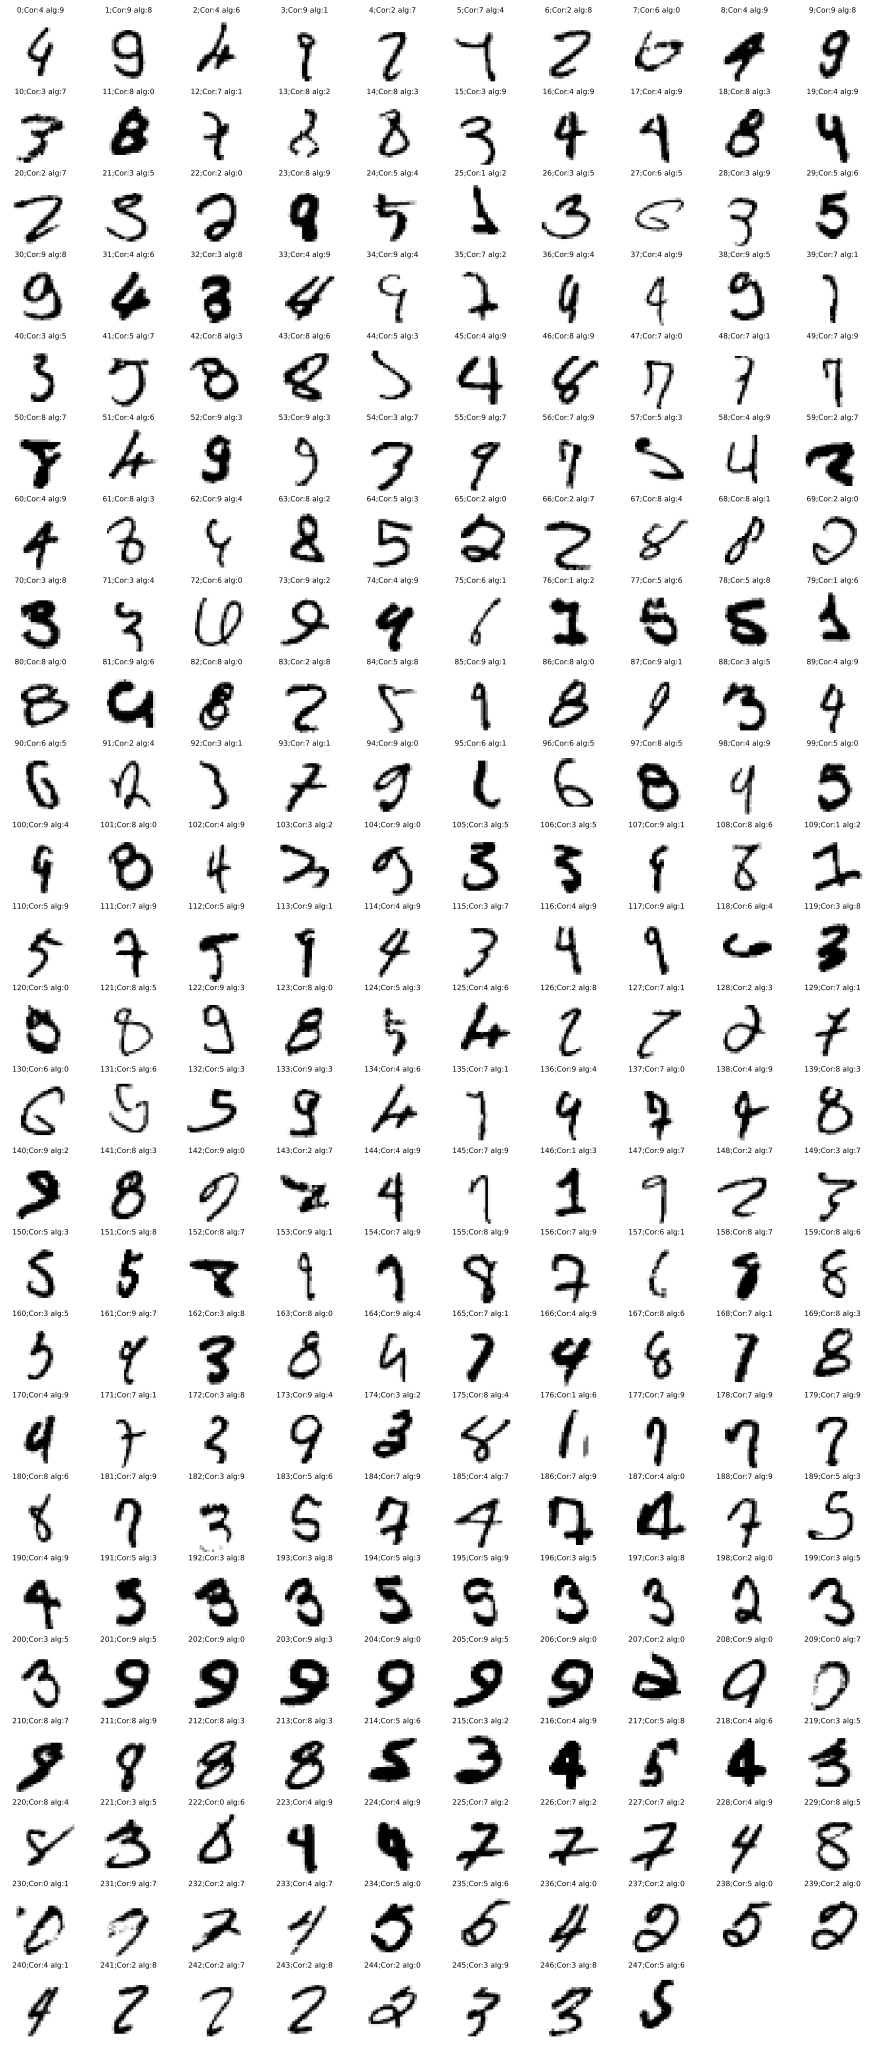

In [14]:
plt.figure(figsize=(17, 40))

for i in range(indexes.shape[0]):
    plt.subplot((indexes.shape[0] + 9) // 10, 10, i + 1)
    plt.title(str(i) + ';Cor:' + str(y_test[indexes[i]]) + ' alg:' + str(y_pred[indexes[i]]), fontsize=8)
    plt.imshow(objects[indexes[i]], cmap='Greys')
    plt.axis('off')
plt.savefig('experiment4_errors.pdf')
plt.show()

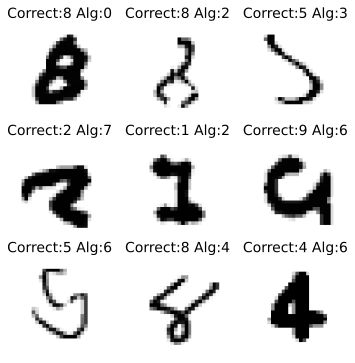

In [15]:
plt.figure(figsize=(6, 6))

subset = [11, 13, 44, 59, 76, 81, 131, 175, 218]

for i, ind in enumerate(indexes[subset]):
    plt.subplot(3, 3, i + 1)
    plt.title('Correct:' + str(y_test[ind]) + ' Alg:' + str(y_pred[ind]), fontsize=14)
    plt.imshow(objects[ind], cmap='Greys')
    plt.axis('off')
plt.savefig('experiment4_errors_subset.pdf')
plt.show()

### CONCLUSION EXP 4

На кросс-валидации в среднем алгоритм работает лучше, чем на изначальном разбиении, на 0.0007 секунд.  
По confusion matrix можно понять, что алгоритм часто вместо 4 и 7 ставит 9. 3 принимает за 5. 7 принимает за 1.  
Из визуализации объектов, на которых были допущены ошибки, можно увидеть, что из объединяют некоторые особенности  
и дефекты: пропуски, большая толщина, неровный почерк, крутой наклон, поворот вокруг центра, отличающийся от среднего масштаб.

## EXPERIMENT 5

### DESCRIPTION EXP 5

Требуется произвести аугментацию обучающей выборки. Необходимо использовать повороты, смещения,  
морфологические операции (эрозия, дилатация, открытие, закрытие с ядром 2), гауссовский фильтр.  
Величины преобразований, которые неоходимо рассмотреть:

1. Величина поворота: 5, 10, 15 градусов (в обе стороны)
2. Величины смещения: 1, 2, 3 пикселя (по 4 направлениям осей)
3. Дисперсия фильтра Гаусса: 0.5, 1, 1.5  

Необходимо по кросс-валидации на 3 фолдах подобрать параметры преобразований.  
Требуется проанализировать, какие ошибки алгоритма помогает исправить каждое преобразование.

In [3]:
import PIL
import skimage
import scipy
import cv2


def plot_cipher(im):
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(im, cmap='Greys')
    plt.show()

def shift(arr, coords):
    def get_slice(coord, size):
        if coord >= 0:
            return slice(0, size - coord, 1)
        else:
            return slice(-coord, size, 1)
    
    res = np.zeros(arr.shape, dtype=arr.dtype)
    if len(arr.shape) == 2:
        res[get_slice(coords[1], arr.shape[0]), get_slice(-coords[0], arr.shape[1])] = \
        arr[get_slice(-coords[1] , arr.shape[0]), get_slice(coords[0] , arr.shape[1])]
    elif len(arr.shape) == 3:
        res[:, get_slice(coords[1], arr.shape[1]), get_slice(-coords[0], arr.shape[2])] = \
        arr[:, get_slice(-coords[1], arr.shape[1]), get_slice(coords[0] , arr.shape[2])]
    else:
        raise TypeError
    return res

def rotate(arr, angle):
    if len(arr.shape) == 2:
        return skimage.transform.rotate(arr, angle)
    elif len(arr.shape) == 3:
        return np.array([skimage.transform.rotate(obj, angle) for obj in arr])
    else:
        raise TypeError

def gaussian_blur(arr):
    ksize = (3, 3)
    sigmaX = 1.0
    if len(arr.shape) == 2:
        return cv2.GaussianBlur(arr, ksize, sigmaX)
    elif len(arr.shape) == 3:
        return np.array([cv2.GaussianBlur(obj, ksize, sigmaX) for obj in arr])
    else:
        raise TypeError

def erosion(arr):
    kernel = np.ones((2, 2))
    iters = 1
    if len(arr.shape) == 2:
        return cv2.erode(arr, kernel, iters)
    else:
        return np.array([cv2.erode(obj, kernel, iters) for obj in arr])

def dilation(arr):
    kernel = np.ones((2, 2))
    iters = 1
    if len(arr.shape) == 2:
        return cv2.filate(arr, kernel, iters)
    else:
        return np.array([cv2.dilate(obj, kernel, iters) for obj in arr])

def opening(arr):
    kernel = np.ones((2, 2))
    if len(arr.shape) == 2:
        return cv2.morphologyEx(arr, cv2.MORPH_OPEN, kernel)
    else:
        return np.array([cv2.morphologyEx(obj, cv2.MORPH_OPEN, kernel) for obj in arr])

def closing(arr):
    kernel = np.ones((2, 2))
    if len(arr.shape) == 2:
        return cv2.morphologyEx(arr, cv2.MORPH_CLOSE, kernel)
    else:
        return np.array([cv2.morphologyEx(obj, cv2.MORPH_CLOSE, kernel) for obj in arr])

In [17]:
cip = X_test[indexes[1]].reshape(28, 28).copy()

(60000, 28, 28)
0.2032163143157959


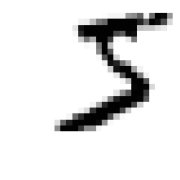

(60000, 28, 28)


In [4]:
smth = X_train.reshape(-1, 28, 28)
print(smth.shape)
start = time()
smth = shift(smth, (4, 4))
end = time()
print(end - start)
plot_cipher(smth[0])
print(smth.shape)

(60000, 28, 28)
9.88436770439148


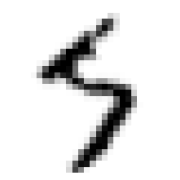

(60000, 28, 28)


In [20]:
smth = X_train.reshape(-1, 28, 28)
print(smth.shape)
start = time()
smth = rotate(smth, 30)
end = time()
print(end - start)
plot_cipher(smth[0])
print(smth.shape)

(60000, 28, 28)


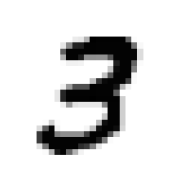

0.7292940616607666


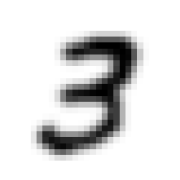

(60000, 28, 28)


In [22]:
smth = X_train.reshape(-1, 28, 28)
print(smth.shape)
plot_cipher(smth[7])
start = time()
smth = gaussian_blur(smth)
end = time()
print(end - start)
plot_cipher(smth[7])
print(smth.shape)

(60000, 28, 28)


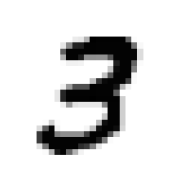

0.744267463684082


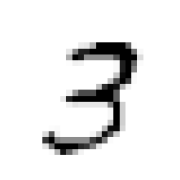

(60000, 28, 28)


In [29]:
smth = X_train.reshape(-1, 28, 28)
print(smth.shape)
plot_cipher(smth[7])
start = time()
smth = erosion(smth)
end = time()
print(end - start)
plot_cipher(smth[7])
print(smth.shape)

(60000, 28, 28)


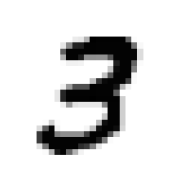

0.7463769912719727


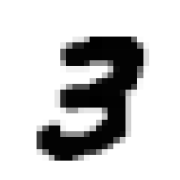

(60000, 28, 28)


In [33]:
smth = X_train.reshape(-1, 28, 28)
print(smth.shape)
plot_cipher(smth[7])
start = time()
smth = dilation(smth)
end = time()
print(end - start)
plot_cipher(smth[7])
print(smth.shape)

(60000, 28, 28)


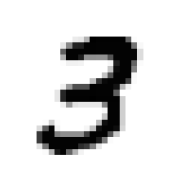

0.7037887573242188


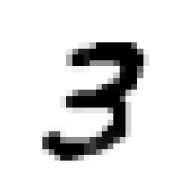

(60000, 28, 28)


In [46]:
smth = X_train.reshape(-1, 28, 28)
print(smth.shape)
plot_cipher(smth[7])
start = time()
smth = opening(smth)
end = time()
print(end - start)
plot_cipher(smth[7])
print(smth.shape)

(60000, 28, 28)


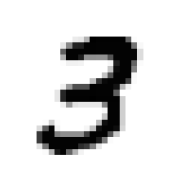

0.7671952247619629


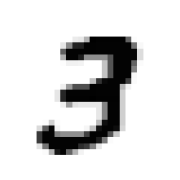

(60000, 28, 28)


In [42]:
smth = X_train.reshape(-1, 28, 28)
print(smth.shape)
plot_cipher(smth[7])
start = time()
smth = closing(smth)
end = time()
print(end - start)
plot_cipher(smth[7])
print(smth.shape)

In [1]:
X_cool_train = erosion(X_train.reshape(-1, 28, 28)).reshape(-1, 784)
print(X_cool_train.shape)

NameError: name 'erosion' is not defined

In [ ]:
knn = KNNClassifier(k=4, strategy='my_own', metric='cosine', weights=True, test_block_size=1000)
knn.fit(X_cool_train, y_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_test, y_pred))

### CONCLUSION EXP 5

Some text